<a href="https://colab.research.google.com/github/amitkp57/Jupyter/blob/dev-muh/Jupyter-muhammad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Move to GPU mode if you are in Google Colab
Go to `Runtime` -> `Change runtime type` to activate GPU.

### Provide your credentials to the runtime


In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Mount Google Drive

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
WORKING_DIRECTORY = '/content/gdrive/MyDrive/Data/Jupyter/Jupyter'
os.environ['WORKING_DIRECTORY'] = WORKING_DIRECTORY
%cd $WORKING_DIRECTORY/
!ls -latr data/query_tables/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data/Jupyter/Jupyter
total 2283410
-rw------- 1 root root   407756 Mar 10 14:48 bigquery-public-data.covid19_aha.staffing.npy
-rw------- 1 root root  1980928 Mar 10 14:48 bigquery-public-data.covid19_ecdc.covid_19_geographic_distribution_worldwide.npy
-rw------- 1 root root  1980928 Mar 10 14:48 bigquery-public-data.covid19_ecdc_eu.covid_19_geographic_distribution_worldwide.npy
-rw------- 1 root root    39688 Mar 10 14:48 bigquery-public-data.covid19_geotab_mobility_impact.airport_traffic.npy
-rw------- 1 root root   317140 Mar 10 14:48 bigquery-public-data.covid19_geotab_mobility_impact.city_congestion.npy
-rw------- 1 root root  1287596 Mar 10 14:48 bigquery-public-data.covid19_geotab_mobility_impact.commercial_traffic.npy
-rw------- 1 root root   106972 Mar 10 14:48 bigquery-public-data.covid19_geotab_mobility_impact.commercial_traffic_by_industry.npy
-rw------- 1 root root    20320 Mar 10 14:49 bigquery-public-data.covid19_geotab_m

### Clone git repo

In [ ]:
%cd $WORKING_DIRECTORY
# !git clone https://github.com/amitkp57/Jupyter
!git pull
!pip install -r requirements.txt

/content/gdrive/MyDrive/Data/Jupyter/Jupyter
Already up to date.


### Setup meta data

Creates datasets.txt, tables.txt and columns.json in the /data folder. These files are used for querying Google Bigquery tables. 

In [ ]:
from scripts.MetaData import save_locally
DATA_PATH = f'{WORKING_DIRECTORY}/data'
save_locally(DATA_PATH)
print('Completed!')

## Test code

#### Reload scripts (if changed on GDrive)

In [ ]:
# %cat $WORKING_DIRECTORY/scripts/QueryDatabase.py
# %load_ext autoreload
# %autoreload 2
import importlib
importlib.reload(qd)

<module 'scripts.QueryDatabase' from '/content/gdrive/My Drive/Data/Jupyter/Jupyter/scripts/QueryDatabase.py'>

#### just testing

In [ ]:
import scripts.QueryDatabase as qd
print(curr_cols)
test = qd.get_columns_values('bigquery-public-data.covid19_nyt.excess_deaths', curr_cols)
test


['month', 'week', 'deaths', 'expected_deaths', 'excess_deaths']


array([[1.000e+00, 2.000e+00, 3.000e+00, ..., 1.200e+01, 1.200e+01,
        1.200e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.200e+01, 5.200e+01,
        5.200e+01],
       [4.538e+03, 4.244e+03, 4.312e+03, ..., 1.758e+03, 1.306e+03,
        9.683e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float32)

#### Query and save (support resume table and query single table)

In [ ]:
import scripts.QueryDatabase as qd
import numpy as np

exclude_types = ['STRING', 'GEOGRAPHY', 'DATE', 'DATETIME', 'TIMESTAMP']
all_cols = qd.get_columns_exclude(exclude_types)
columns = []
print('Column len: %d' % len(all_cols))

# Aggregate multiple columns with the same table
prev_cols = all_cols[0]
curr_cols = []
col_th = 30
resume_table = 'bigquery-public-data.covid19_aha.hospital_beds'
cont_flag = False
is_single = True
suffix = 0
# resume
for cols in all_cols:
  if (not cont_flag):
    if (resume_table == cols['table']):
      cont_flag = True
      prev_cols = cols
    else:
      prev_cols = cols
      continue
  if (len(curr_cols) == col_th or prev_cols['table'] != cols['table']):
    print(prev_cols['table'] + ': ' + ','.join(curr_cols))
    result = qd.get_columns_values(prev_cols['table'], curr_cols, 30000)
    suff_str = ''
    if suffix > 0:
      suff_str += str(suffix)
    with open(f'{os.environ["WORKING_DIRECTORY"]}/data/query_tables/' + prev_cols['table'] + suff_str + '.npy', 'wb') as file:
      np.save(file, result)
    curr_cols = [ cols['column'] ]
    if prev_cols['table'] != cols['table']:
      if is_single:
        break
      suffix = 0
    else:
      suffix += 1
  else:
    curr_cols.append(cols['column'])
  prev_cols = cols
# Get the last columns
if not is_single:
  print(prev_cols['table'] + ': ' + ','.join(curr_cols))
  result = qd.get_columns_values(prev_cols['table'], curr_cols, 30000)
  suff_str = ''
  if suffix > 0:
    suff_str += str(suffix)
  with open(f'{os.environ["WORKING_DIRECTORY"]}/data/query_tables/' + prev_cols['table'] + suff_str + '.npy', 'wb') as file:
    np.save(file, result)

print('Column2 len: %d' % len(columns))

Column len: 8842
bigquery-public-data.covid19_aha.hospital_beds: cbsa_code,total_hospital_beds,acute_long_term_care_beds,alcohol_drug_abuse_dependency_inpatient_care_beds,burn_care_beds,cardiac_intensive_care_beds,gen_medical_surgical_adult_beds,gen_medical_surgical_pediatric_beds,intermediate_nursing_care_beds,medical_surgical_intensive_care_beds,neonatal_intensive_care_beds,neonatal_intermediate_care_beds,obstetric_care_beds,other_care_beds,other_intensive_care_beds,other_long_term_care_beds,other_special_care_beds,pediatric_intensive_care_beds,physical_rehabilitation_care_beds,psychiatric_care_beds,skilled_nursing_care_beds,num_airborne_infection_isolation_rooms
Column2 len: 0


#### Load saved queried columns

In [4]:
from os import listdir
from os.path import isfile, join
import numpy as np

datapath = f'{os.environ["WORKING_DIRECTORY"]}/data/query_tables/'
onlyfiles = [f for f in listdir(datapath) if isfile(join(datapath, f))]
columns = []
for file_name in onlyfiles:
  with open(f'{os.environ["WORKING_DIRECTORY"]}/data/query_tables/' + file_name, 'rb') as file:
    temp = np.load(file)
    for col in temp:
      columns.append(col)

print('Column2 len: %d' % len(columns))

Column2 len: 8842


#### Calculate correlation

In [5]:
import numpy as np
import scipy.stats as stats

corr_list = []
# max_range = len(columns)
max_range = 100

for i in range(max_range):
  for j in range(i + 1, max_range):
    len_i = len(columns[i])
    len_j = len(columns[j])
    temp_i = columns[i]
    temp_j = columns[j]
    # print('len: %d, %d' % (len_i, len_j))
    if (len_i > len_j):
      np.random.shuffle(temp_i)
      temp_i = temp_i[:len_j]
    elif (len_j > len_i):
      np.random.shuffle(temp_j)
      temp_j = temp_j[:len_i]
    corr_list.append(stats.pearsonr(temp_i, temp_j))

corr_list

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


[(0.18945393422007384, 1.5390530620110056e-22),
 (0.18948054040355147, 1.517975628791918e-22),
 (0.14124090026376812, 4.081996817766501e-13),
 (0.19807890210998783, 1.5821579353295291e-24),
 (0.1923705414501863, 3.3532738408582105e-23),
 (0.09111049149941336, 3.088905858219457e-06),
 (0.174217884473674, 2.965079807946371e-19),
 (0.20461879353516077, 4.2570676102450175e-26),
 (0.10821395933965372, 2.9349754704450143e-08),
 (0.19783782529474087, 1.8033969816023885e-24),
 (0.07844344981569137, 5.967261265436659e-05),
 (0.18482656836106223, 1.6419864387015826e-21),
 (0.18951445406282005, 1.491522734272594e-22),
 (0.18497698867122478, 1.5218400787957876e-21),
 (0.18685323091834258, 5.866414705282971e-22),
 (0.19087080720270458, 7.36368161670353e-23),
 (0.08891985692275597, 5.308622746212954e-06),
 (0.11385902350822619, 5.334289427207764e-09),
 (0.13987317855215775, 6.875982391526678e-13),
 (0.14948232421406984, 1.582229338242818e-14),
 (0.1192148814917122, 9.785941096475027e-10),
 (0.099170

#### 1-D correlation results to 2-D array

In [6]:
range_2d = max_range
# range_2d = 20

corr_2d = []
idx = 0
for i in range(0, range_2d):
  temp = []
  for j in range(0, range_2d):
    if j > i:
      temp.append(corr_list[idx][0])
      idx += 1
    elif i > j:
      temp.append(corr_2d[j][i])
    else:
      temp.append(1.0)
  corr_2d.append(temp)

for row in corr_2d:
  for item in row:
    print('%.5f,' % item, end='')
  print('')

1.00000,0.18945,0.18948,0.14124,0.19808,0.19237,0.09111,0.17422,0.20462,0.10821,0.19784,0.07844,0.18483,0.18951,0.18498,0.18685,0.19087,0.08892,0.11386,0.13987,0.14948,0.11921,0.09917,0.11521,0.19656,0.17242,0.19327,0.04749,0.19743,0.09373,0.06605,0.17849,0.18967,0.14007,0.18843,0.19041,0.19841,0.06234,0.19822,0.00019,0.02276,-0.01829,-0.03251,0.00416,-0.01935,0.00739,-0.00211,0.00761,-0.04397,nan,-0.01349,-0.01861,-0.02050,-0.04269,-0.02225,0.02009,-0.00773,-0.00792,0.00446,0.01446,0.01791,-0.01912,0.00906,0.01533,-0.02800,0.01383,-0.00395,0.00609,0.11563,0.04615,0.03720,0.01116,-0.06064,0.04183,-0.01120,0.04112,0.00206,0.08168,0.03620,-0.03064,-0.05113,0.00496,0.04264,0.00615,-0.11977,0.00878,-0.07469,-0.00987,-0.00640,-0.00680,0.00519,0.01582,-0.02538,0.02470,-0.01379,-0.01998,0.02776,0.01504,0.00836,-0.01747,
0.18945,1.00000,0.99998,0.87288,0.87580,0.99467,0.53172,0.95253,0.82928,0.85391,0.96726,0.71608,0.98260,0.96828,0.97328,0.98730,0.94705,0.49087,0.76493,0.91129,0.85802,0.87928

#### Graph

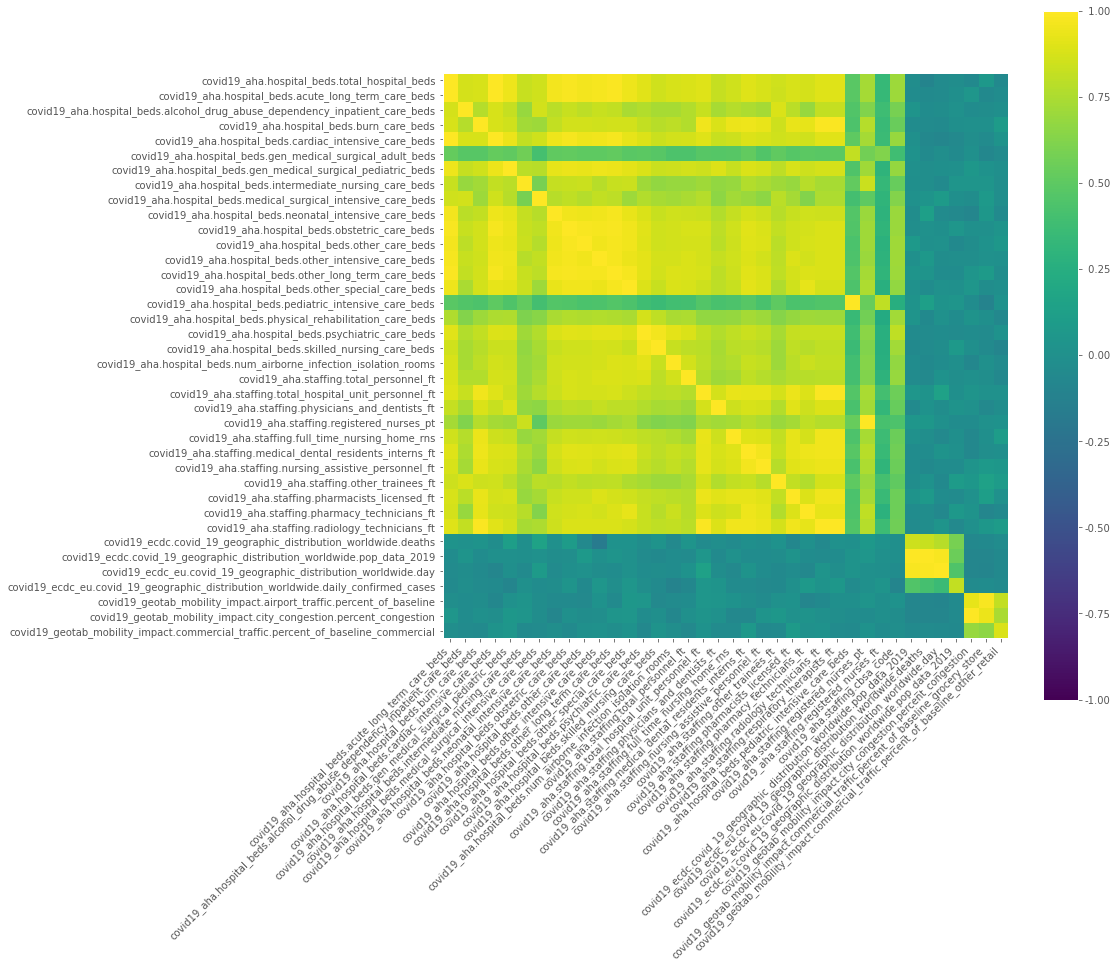

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scripts.QueryDatabase as qd

# params
corr_mat = corr_2d # input correlation matrix
use_label = False  # use label on each cell
corr_th = 0.8      # only include correlation > threshold (-1.0 means include all)

exclude_types = ['STRING', 'GEOGRAPHY', 'DATE', 'DATETIME', 'TIMESTAMP']
all_cols = qd.get_columns_exclude(exclude_types)

col_names_i = []
col_names_j = []
len_i = len(corr_2d)
len_j = len(corr_2d)
if corr_th > -1.0:
  th_i = []
  th_j = []
  for i in range(len_i):
    i_added = False
    for j in range(i+1, len_j):
      if corr_mat[i][j] > corr_th:
        if i not in th_i:
          th_i.append(i)
        if j not in th_j:
          th_j.append(j)

  th_mat = []
  for i in th_i:
    temp = []
    for j in th_j:
      temp.append(corr_mat[i][j])
    th_mat.append(temp)
  corr_mat = th_mat

  len_i = len(th_i)
  len_j = len(th_j)

  for i in th_i:
    col_names_i.append('%s.%s' % (all_cols[i]['table'][21:], all_cols[i]['column']))
  for j in th_j:
    col_names_j.append('%s.%s' % (all_cols[j]['table'][21:], all_cols[j]['column']))
else:
  for i in range(len_i):
    col_names_i.append('%s.%s' % (all_cols[i]['table'][21:], all_cols[i]['column']))
  col_names_j = col_names_i

plt.rcParams["figure.figsize"] = (len_j/3, len_i/3) # image size

fig, ax = plt.subplots()
im = ax.imshow(corr_mat)
im.set_clim(-1, 1)
ax.grid(False)
ax.set_xticks(range(len_j))
ax.set_xticklabels(col_names_j, rotation=45, ha='right')
ax.yaxis.set(ticks=range(len_i), ticklabels=col_names_i)
ax.set_ylim(len_i - 0.5, -0.5)
if use_label:
  for i in range(mat_len):
      for j in range(mat_len):
          ax.text(j, i, '%.2f' % corr_2d[i][j], ha='center', va='center',
                  color='r')
cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()


#### Save Pearson correlations results

In [ ]:
import json
with open(f'{os.environ["WORKING_DIRECTORY"]}/data/pearson_corr.json', 'w') as file:
  json.dump(corr_list, file)

#### Load Pearson correlation results

In [ ]:
import json
with open(f'{os.environ["WORKING_DIRECTORY"]}/data/pearson_corr.json') as file:
  test = json.load(file)

test

[[-0.006526964844085435, 0.7387673714516878],
 [0.0054184149723924, 0.7818988230877747],
 [0.02051332504289797, 0.2945470754391142],
 [0.01795143727301378, 0.3590024097377273],
 [-0.010361088243693199, 0.5965322719876853],
 [-0.012006415353817228, 0.5395679110079318],
 [-0.00523577061093342, 0.7890739461212976],
 [0.010506753040250129, 0.5913802771906213],
 [-0.015505687399839882, 0.42819712075869854],
 [-0.012343962216362685, 0.5282270584606461],
 [-0.008466811886964668, 0.6653031947310858],
 [-0.011975834372483923, 0.5406013544818378],
 [0.005643486901572685, 0.7730824571762809],
 [0.015542468615597615, 0.42710221242048935],
 [-0.011090418172045289, 0.5709446942628008],
 [-0.0036513646797459625, 0.8520056389821684],
 [-0.006757667071164244, 0.7298885545072841],
 [-0.01989914343563916, 0.3092444617719443],
 [-0.0008950279737798343, 0.9635256748773979],
 [-0.0005344374545992743, 0.978215637003314],
 [-0.0013989859567685096, 0.9430169365853387],
 [0.01954816127835654, 0.3178573434245278